# Comparison of root architecture and water uptake models 17 May 2018. Workshop Root architecture and water uptake, 17 May 2018 at Forschungszentrum Jülich

Convenors: Andrea Schnepf, Guillaume Lobet, Mathieu Javaux

Authors: Andrea Schnepf, Daniel Leitner

Three–dimensional models of root growth, architecture and function are currently evolving as they are becoming important tools that aid in the design of agricultural management schemes and in the selection of root traits for improving plant performance in specific environments. However, while benchmarking is generally common for water and solute transport models in soil, 3D root-soil interaction models have never been systematically analysed. Several interacting processes might induce discrepancy between models: (1) root growth, (2) sink term definitions of root water and solute uptake, (3) representation of the rhizosphere. The extent of potential inaccuracies is currently unknown.

We propose to define a common framework for quantitatively comparing our model outputs on two different aspects, 3D root growth and root water uptake. The strategy of how to do the model comparisons will be the outcome of the workshop.
 ***

## Benchmarking root architecture models

Text to exlain the root architecture model benchmarking
***

## Benchmarking root water uptake models
Text to explain the root water uptake benchmarking

The following code is the analytical solution of 1D Richards equation in soil.

### Python modules needed for analytical solution

In [3]:
# %load C:\Users\a.schnepf\AppData\Local\Continuum\anaconda3\Lib\van_genuchten.py
#
# Mualem - van Genuchten model, equations from van Genuchten, MT 1980
# 
import math
import numpy as np

#
# pascal to pressure head, converts a numpy array 
#
def pa2head(pa_, pnref = 1.e5, g = -9.81):
    h = np.zeros(len(pa_))
    for i,p in enumerate(pa_):
        h[i] = -(p-pnref)/10./g 
    return h
   
#
# pressure to pascal, converts a numpy array 
#      
def head2pa(h_, pnref = 1.e5, g = -9.81):
    pa = np.zeros(len(h_))
    for i,h in enumerate(h_):
        pa[i] = h*10.*g 
    return pnref-pa

#
# class containing the van genuchten parameters
#
class Parameters:
    def __init__(self, R, S, alpha, n, m, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = m
        self.Ksat = Ksat
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

#
# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
#
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

#
# returns pressure head at a given volumetric water content according to the van genuchten model
#
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

#
# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
#
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

#
# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
#
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*math.sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

#
# returns the specific moisture storage according to the van genuchten model
#
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C



### Analytical solution which produces Figure 2abc of Vanderborght et al. 2005

C:\Users\a.schnepf\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


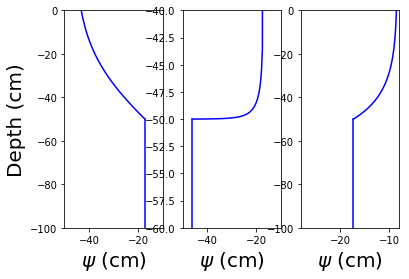

In [13]:
#
# produces the analytical solution Figure 2abc
# from Vanderborght et al 2005
#
# D. Leitner, 2018
#
import numpy as np
from scipy import optimize
from scipy import integrate
import van_genuchten as vg
import matplotlib.pyplot as plt
%matplotlib inline  

sand = vg.Parameters(0.045, 0.43, 0.15, 3, 1.1574e-04*100*3600*24)
loam = vg.Parameters(0.08, 0.43, 0.04, 1.6, 5.7870e-06*100*3600*24)
clay = vg.Parameters(0.1, 0.4, 0.01, 1.1, 1.1574e-06*100*3600*24)

Jw = 0.5;  # constant downward flow rate [cm/d]

#
# The lower part (constant pressure)
#
Ks = lambda psi: vg.hydraulic_conductivity(psi,sand)-Jw
Kl = lambda psi: vg.hydraulic_conductivity(psi,loam)-Jw
Kc = lambda psi: vg.hydraulic_conductivity(psi,clay)-Jw
psi_s = optimize.brentq(Ks, -100, 0);
psi_l = optimize.brentq(Kl, -100, 0);
psi_c = optimize.brentq(Kc, -100, 0);

 # 
# The upper part
#
Ks = lambda psi: vg.hydraulic_conductivity(psi,sand)
Kl = lambda psi: vg.hydraulic_conductivity(psi,loam)
Kc = lambda psi: vg.hydraulic_conductivity(psi,clay)
# integrand Eqn [14]
Fs = lambda psi: 1./(Jw/Ks(psi) - 1.) 
Fl = lambda psi: 1./(Jw/Kl(psi) - 1.)
Fc = lambda psi: 1./(Jw/Kc(psi) - 1.)
    
N = 100 # resolution
dz = np.ones(N,)
    
psiA = np.linspace(-45,psi_s,N) # Loam (on sand)
for i in range(0,N):
    ans, err = integrate.quad(Fl,psi_s, psiA[i])
    dz[i] = ans
zA = dz - 50. 
     
psiB = np.linspace(psi_l,psi_s-1e-10,N) # Sand (on loam)
for  i in range(0,N):
    ans, err = integrate.quad(Fs,psi_l,psiB[i]);
    dz[i] = ans
zB = dz + -50;
    
     
psiC = np.linspace(psi_s,psi_c-1e-3,100); # Clay (on sand)
for  i in range(0,N):    
    ans, err = integrate.quad(Fc,psi_s,psiC[i]);
    dz[i] = ans    
zC = dz + (-50);
    
    
#
# prepare plot
#
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
z_ = np.linspace(-50,-100,2)
ax1.plot([psi_s,psi_s],z_,'b') # sand
ax1.plot(psiA,zA,'b');
ax1.set_xlabel('$\psi$ (cm)',fontsize=20);
ax1.set_ylabel('Depth (cm)',fontsize=20);
ax1. set_xlim(-50,-10)
ax1.set_ylim(-100,0)
    
z_ = np.linspace(-50,-100,2)
ax2.plot([psi_l,psi_l],z_,'b')
ax2.plot(psiB,zB,'b');
ax2.set_xlabel('$\psi$ (cm)',fontsize=20); # loam
ax2.set_xlim(-50,-10)
ax2.set_ylim(-60,-40)
    
z_ = np.linspace(-50,-100,2)
ax3.plot([psi_s,psi_s],z_,'b') # sand
ax3.plot(psiC,zC,'b');
ax3.set_xlabel('$\psi$ (cm)',fontsize=20);
ax3.set_xlim(-28,-8)
ax3.set_ylim(-100,0)

plt.show()

### Analytical solution which produces Figures 4abc from Vanderborght et al. (2005)

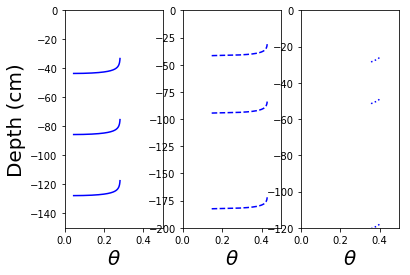

In [12]:
#
# produces the analytical solution Figure 4abc
# from Vanderborght et al 2005
#
# D. Leitner, 2018
#
import numpy as np
from scipy import optimize
from scipy import integrate
import van_genuchten as vg
import matplotlib.pyplot as plt
%matplotlib inline  

sand = vg.Parameters(0.045, 0.43, 0.15, 3, 1.1574e-04*100*3600*24)
loam = vg.Parameters(0.08, 0.43, 0.04, 1.6, 5.7870e-06*100*3600*24)
clay = vg.Parameters(0.1, 0.4, 0.01, 1.1, 1.1574e-06*100*3600*24)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax = [ax1,ax2,ax3]

for i, soil in enumerate([sand, loam, clay]): # make three subplots
        
    if soil==sand:
        theta_sur = 0.2824
    else:
        theta_sur = soil.theta_S
        
    theta_i = vg.water_content(-400,soil);
        
    K_sur = vg.hydraulic_conductivity( vg.pressure_head(theta_sur,soil), soil);
    K_i = vg.hydraulic_conductivity(-400, soil)
    psi = lambda theta: vg.pressure_head(theta,soil)
    K = lambda psi: vg.hydraulic_conductivity(psi,soil)
    Dw = lambda psi: K(psi)/(vg.specific_moisture_storage(psi,soil))
            
    F = lambda theta:  Dw(psi(theta)) / ( (K_sur - K_i)*(theta - theta_i) - (K(psi(theta)) - K_i)*(theta_sur - theta_i) ) 
    
    theta_a = (theta_sur+theta_i)/2
    
    if soil==clay: # todo: same same?
        theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,300)
    else:
        theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,300)

    delta_eta = np.zeros(len(theta_),)
    for j in range(0,len(theta_)):
        ans, err = integrate.quad(F,theta_[j],theta_a)
        delta_eta[j] = ans
    
    delta_eta = delta_eta * (theta_sur - theta_i)
    
#     %figure(1)
#     % plot(theta_, delta_eta,'k-','linewidth',2)
#     % set(gca,'Ydir','reverse')
#     % xlabel('\theta');
#     % ylabel('\Delta\eta (cm)');
#     % axis([0,0.5,-10,5]);
    
    tv=[ [0.1, 0.2, 0.3],
         [0.2, 0.5, 1.0], 
         [0.1, 0.2, 0.5]]     

    x_aa = [43, 41, 27.5]  # [42.14103, 35.21381052, 23.0052]; %50;  #  how to choose reference water content and its position ????
    x_a = x_aa[i]
    
    t_a2 = [0.1, 0.2, 0.1] 
    t_a = t_a2[i]
        
    eta_a = x_a - (K_sur-K_i)/(theta_sur - theta_i)*t_a
    eta = delta_eta + eta_a

    # finally, plot the thing    
    lineStyle= ['b-','b--','b:'] 
    for j in range(0,len(tv[0])):
        t = tv[i][j]
        x = eta  + (K_sur - K_i) * t / (theta_sur - theta_i);
        ax[i].plot(theta_,-x,lineStyle[i])
    
    ax[i].set_xlabel(r'$\theta$')
    ax[i].set_xlim(0,0.5)

ax1.set_ylabel('Depth (cm)',fontsize=20);
ax1.set_xlabel(r'$\theta$',fontsize=20);
ax1.set_xlim(0,0.5)
ax1.set_ylim(-150,0)

ax2.set_xlabel(r'$\theta$',fontsize=20);
ax2.set_xlim(0,0.5)
ax2.set_ylim(-200,0)

ax3.set_xlabel(r'$\theta$',fontsize=20);
ax3.set_xlim(0,0.5)
ax3.set_ylim(-120,0)

plt.show()

### Analytical solution of water flow inside root system

In [6]:
%%javascript
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
;

<IPython.core.display.Javascript object>

#### Equations describing water flow within the root system

Roughly based on \cite{Doussan-06}, \cite{Roose-04a}.

The axial water flux in a xylem is given by 
\begin{eqnarray}
q_z = - k_z \left( \frac{\partial p_r}{\partial z} - \rho g \mathbf{e}_z \cdot \mathbf{v} \right), \label{axialflux}
\end{eqnarray}
with units [L$^3$ T$^{-1}$] \citep[see Eqn 3.1][]{Roose-04a}. 
The parameter $k_z$ is the axial conductance [$L^5$ T M$^{-1}$], 
$p_r$ is the pressure inside the xylem [M L$^{-1}$ T$^{-2}$], 
$\rho$ is the density of water [M L$^{-3}$], 
$g$ is the gravitational acceleration [L T$^{-2}$], 
$\mathbf{e}_z$ the downward unit vector [1],
and $\mathbf{v}$ the normed direction of the xylem [1]. Thus Eqn (\ref{axialflux}) can be expressed as
\begin{eqnarray}
q_z = - k_z \left( \frac{\partial p_r}{\partial z} - \rho g \mathbf{v}_3 \right),
\end{eqnarray}
where $\mathbf{v}_3$ is the $z$-component of the normed xylem direction. 

The radial flux is given by 
\begin{eqnarray}
q_r = - 2 a \pi l k_r (p_s - p_r) 
\end{eqnarray}
with units [L$^3$ T$^{-1}$] \citep[based on Eqn 3.3][]{Roose-04a}, 
where $a$ is the root radius [L], $l$ is the segments length [L], 
$k_r$ is the radial conductance [L$^2$ T M$^{-1}$], 
and $p_s$ is the pressure of the surrounding soil [M L$^{-1}$ T$^{-2}$]. 

The net flux is
\begin{eqnarray}
q = q_z + q_r.
\end{eqnarray}

In a graph that represents the root system for each node $i$ the sum of fluxes must be zero (first Kirchhoff's law)
\begin{eqnarray}
\sum_{j \in N(i)} q_{ij} = 0,  \label{KH}
\end{eqnarray}
where $N(i)$ are the nodes connected to node $i$ and $q_{ij}$ is the net flux of the edge connecting node $i$ and node $j$.

#### Discretisation
In the graph the pressure $p_i$ is defined for each node $n_i$. 
The edges at node $n_i$ are denoted as $e_{ij}$ with $j \in N(i)$, where $N(i)$ are the indices of the neighbouring nodes. 
Thus, the edge $e_{ij}$ connects node $n_i$ and node $n_j$ for each $j \in N(i)$. \\

For each edge $e_{ij}$ the axial water flux from $n_i$ to $n_j$ is 
\begin{eqnarray}
q_{z,ij} = - k_z ( \frac{p_j-p_i}{l_{ij}}  - \rho g \mathbf{v}_{ij,3} ),
\end{eqnarray}
and the radial flux from segment $e_{ij]$ into the soil is 
\begin{eqnarray}
q_{r,ij} = - 2 a_{ij} \pi l_{ij} k_r (p_s - p_{ij}), 
\end{eqnarray}
where $l_{ij}$ is the length, $\mathbf{v}_{ij}$ the normed direction, $a_{ij}$ the radius, $p_{ij}$ is the mean edge pressure ($p_{ij} = \frac{p_i+p_j}{2}$) of the edge $e_{ij}$. 
The value $p_s$ is the soil potential, surrounding the edge $e_{ij}$. 
The, net flux of a node is the sum of all axial fluxes $q_{z,ij}$ and half of the radial fluxes $q_{r,ij}$:
\begin{eqnarray}
q_{ij} &=&  - a_{ij} \pi l_{ij} k_r p_s + k_z \rho g \mathbf{v}_{ij,3}  \nonumber \\
& & \frac 1 2 a_{ij} \pi l_{ij} k_r p_i + \frac{1}{l_{ij}} k_z p_i  \nonumber \\
& & \frac 1 2 a_{ij} \pi l_{ij} k_r p_j - \frac{1}{l_{ij}} k_z  p_j.   \label{netflux}
\end{eqnarray} 

Eqn \ref{KH} states that all fluxes into each node cancel out. This can be presented as a linear equation  
\begin{eqnarray}
\left( C \mathbf{p} \right)_i =  \sum_{j \in N(i)} c_{ii} p_i + c_{ij} p_j = b_i, \label{linearsystem}
\end{eqnarray}
where each row $i$ of $C$ represents the linear equation for node $i$. 
The diagonal elements of $C$ are derived by the second line of Eqn (\ref{netflux}):
\begin{eqnarray}
c_{ii} := \sum_{j \in N(i)} \frac 1 2 a_{ij} \pi l_{ij} k_r + \frac{1}{l_{ij}} k_z, 
\end{eqnarray}
with $c_{ii}=c_{jj}$, and the other entries by the third line of Eqn (\ref{netflux}):
\begin{eqnarray}
c_{ij} := \sum_{j \in N(i)} \frac 1 2  a_{ij} \pi l_{ij} k_r - \frac{1}{l_{ij}} k_z, 
\end{eqnarray}
with $c_{ij}=c_{ji}$. 
The value $b_i$ is derived from first line of Eqn (\ref{netflux}): 
\begin{eqnarray}
b_i := \sum_{j \in N(i)} a_{ij} \pi l_{ij} k_r p_s - k_z \rho g \mathbf{v}_{ij,3},
\end{eqnarray}
and 
\begin{eqnarray}
b_j := \sum_{j \in N(i)} a_{ij} \pi l_{ij} k_r p_s + k_z \rho g \mathbf{v}_{ij,3},
\end{eqnarray}
because $\mathbf{v}_{ij,3} = - \mathbf{v}_{ji,3}$. This yields the linear system $Cp = b$ of Eqn (\ref{linearsystem}). 

Note that $C$ is symmetric (since the graph is undirected) and sparse (most $c_{ij}$ are zero, since all $c_{ij}$ are zero where node $i$ and node$j$ are not connected by an edge). 
The soil matric potential $p_s$ and the direction of the edges $\mathbf{v}_{ij}$ only enter the equation on the rhs affecting $b_i$.

#### Boundary conditions
For simplicity we assume a no-flux boundary condition at the root tips. This is a simplification, however, water can enter or leave radially in the edge representing the root tip. Therefore, the root tip conductivity can be easily adjusted by changing this edges root radial conductivity $k_r$.

For this reason the only important boundary condition is at the top. Either a Dirichlet boundary condition (fixed potential) or Neumann boundary condition is used (fixed flux). Furthermore, often a combination is applied, where a potential flux is predetermined, but the boundary condition is switched to Dirichlet if the pressure magnitude becomes unreasonable high. 

In the following we assume the top node has index 1, and the root base is represented by a single edge $e_{12}$.

##### Dirichlet
The simplest way to implement a fixed pressure at node 1, is to replace row 1 in the matrix $C$ by $\mathbf{e}_1^T$, and $b_1$ by the desired matric potential $h_{top}$. In this way the equation for node 1 of the linear equation $C p = b$ reads $p_1 = h_{top}$.	

##### Neumann
Neumann boundary condition is implemented, by adding the flux $f_i$ to the specific node $i$ by adding it to the right hands (i.e. $b_i := b_i + f_i$) of the linear equation.

#### Python implementation of this numerical solution and its comparison to analytical solution

In [ ]:
# %load C:\Users\a.schnepf\AppData\Local\Continuum\anaconda3\Lib\xylem_flux.py
import math
import numpy as np
from scipy import sparse
from numpy.linalg.linalg import norm

#
# Creates the linear system describing the pressure inside a xylem network
#
# in:
# seg     numpy array (Ns,2) of segment indices [1]
# nodes   numpy array (N,3) of the node coordinates [L]
# radius  segment radii [L]
# kr      radial conductivity for each segment [L2 T M−1]
# kz      axial conductivity for each segment [L5 T M-1]
# rho     density of soil water [M L-3]
# g       gravitational acceleration [L T−2]
# soil_p  lambda function returning the soil matric potential at a given location, p=soil_p(x,y,z) [M L−1 T−2]
#
# out: 
# Q,b     The equations are represented by the linear system Qx=b
# 
def linear_system(seg, nodes, radius, kr, kz, rho, g, soil_p):

    Ns = seg.shape[0]
    N = nodes.shape[0]
    
    I = np.zeros(4*Ns)
    J = np.zeros(4*Ns)    
    V = np.zeros(4*Ns)
    b = np.zeros(N)
    
    k = 0     

    for c in range(0,Ns):
        
        i = seg[c,0]
        j = seg[c,1]
        
        n1 = nodes[i,:]
        n2 = nodes[j,:]
       
        mid = 0.5*(n1+n2)        
        p_s = soil_p(mid[0],mid[1],mid[2]) # evaluate soil matric potential

        v = n2-n1
        l = norm(v)        
        vz = v[2] / l # normed direction        
        
        a = radius[c]
        
        cii = a*math.pi*l*kr[c]/2 + kz[c]/l # Eqn (10)
        cij = a*math.pi*l*kr[c]/2 - kz[c]/l # Eqn (11)
        bi = a*math.pi*l*kr[c]*p_s # first term of Eqn (12) & (13)            
        
        # edge ij
        b[i] +=  ( bi - kz[c]*rho*g*vz )  # Eqn (12)     
        
        I[k] = i
        J[k] = i     
        V[k] += cii
        k += 1                
        
        I[k] = i
        J[k] = j        
        V[k] += cij
        k += 1 
        
        # edge ji
        i, j = j, i
        b[i] += ( bi + kz[c]*rho*g*vz ) # Eqn (13) 
  
        I[k] = i
        J[k] = i  
        V[k] += cii    
        k += 1                
          
        I[k] = i
        J[k] = j        
        V[k] += cij        
        k += 1 
         
    Q = sparse.coo_matrix((V,(I,J)))    
    Q = sparse.csr_matrix(Q) # Sparse row matrix seems the most reasonable to solve Qx = b iteratively
    
    return (Q, b)

#
# Modifies the linear system to describe Diriclet BC at the node indices n0
#
# in:
# Q, b    the linear system
# n0      node indices where to apply the Dirichlet BC
# d       fixed potential at n0, i.e. len(d)==len(n0)
#
# out:
# Q, b    the updated linear system
#
def bc_dirichlet(Q, b, n0, d):
    c = 0
    for c in range(0, len(n0)):
        i = n0[c]# print("Dirichlet BC at node "+str(i))             
        e0 = np.zeros((1,Q.shape[1])) # build zero vector
        Q[i,:] = sparse.csr_matrix(e0) # replace row i with ei
        Q[i,i] = 1
        b[i] = d[c]    

    return Q, b 

#
# Modifies the linear system to describe a Neumann BC at the segments seg0
#
# in:
# Q, b    the linear system
# n0      node indices where to apply the Dirichlet BC
# f       flux at n0, i.e. len(d)==len(n0)
#
# out:
# Q, b    the updated linear system
#
def bc_neumann(Q, b, n0, f):
    c = 0
    for c in range(0, len(n0)):                
        i = n0[c]  # print("Neumann BC at node "+str(i))       
        b[i] += f[c]        

    return Q, b 

#
# Calculates the axial flux for each segment
#
# in: 
# p       xylem pressure (i.e. solution vector)
# seg     numpy array (Ns,2) of segment indices [1]
# nodes   numpy array (N,3) of the node coordinates [L]
# kz      axial conductivity for each segment [L5 T]
# rho     density of soil water [M L-3]
# g       gravitational acceleration [L T−2]
#
# out:
# the axial flux
def axial_flux(p, seg, nodes, kz, rho, g):
    af = np.zeros(seg.shape[0])
    c = 0
    for s in seg:
        i = s[0]
        j = s[1]        
        v = nodes[j,:]-nodes[i,:] # segment direction
        l = norm(v) # length        
        v = v / l # normed direction           
        af[c] = -kz[c]*((p[j]-p[i])/l+rho*g*v[2])  # Eqn (6)
        c += 1
        
    return af

#
# Calculates the axial flux for the top segment
#
# in:
# p       xylem pressure (i.e. solution vector) 
# seg     numpy array (Ns,2) of segment indices [1]
# nodes   numpy array (N,3) of the node coordinates [L]1]
# kz      axial conductivity for each segment [L5 T]
# rho     density of soil water [M L-3]
# g       gravitational acceleration [L T−2]
#
# out:
# the axial flux
def axial_flux0(p, seg, nodes, kz, rho, g):
    s = seg[0]
    i = s[0]
    j = s[1]        
    v = nodes[j,:]-nodes[i,:] # segment direction
    l = norm(v) # length        
    v = v / l # normed direction           
    af = -kz[0]*((p[j]-p[i])/l+rho*g*v[2])  # Eqn (6)
    return af

#
# Calculates the radial flux for each segment
#
# in:
# p       xylem pressure (i.e. solution vector) 
# seg     numpy array (Ns,2) of segment indices [1]
# nodes   numpy array (N,3) of the node coordinates [L]
# radius  segment radii [L]
# kr      radial conductivity for each segment [L2 T M−1]
# soil_p  lambda funciton returning the soil matric potential at a given location, p=soil_p(x,y,z) [M L−1 T−2]
#
# out:
# the radial flux [L3 T-1] its radial flow
def radial_flux(p, seg, nodes, radius, kr, soil_p):
    rf = np.zeros(seg.shape[0])
    c = 0
    for s in seg:
        i = s[0]
        j = s[1] 
        n1 = nodes[i,:]
        n2 = nodes[j,:]       
        l = norm(n2-n1) # length
        a = radius[c]
        mid = (n1+n2)/2 # segment mid point 
        ps = soil_p(mid[0],mid[1],mid[2])
        rf[c] = -2*a*math.pi*l*kr[c]*(ps-(p[j]+p[i])/2) # Eqn (7)
        c += 1
                
    return rf

#
# Calculates the radial net for each segment
#
# in:
# p       xylem pressure (i.e. solution vector) 
# seg     numpy array (Ns,2) of segment indices [1]
# nodes   numpy array (N,3) of the node coordinates [L]
# radius  segment radii [L]
# kr      radial conductivity for each segment [L2 T M−1]
# kz      axial conductivity for each segment [L5 T]
# rho     density of soil water [M L-3]
# g       gravitational acceleration [L T−2]
# soil_p  lambda funciton returning the soil matric potential at a given location, p=soil_p(x,y,z) [M L−1 T−2]
#
# out:
# the net flux
def net_flux(p,seg, nodes, radius, kr, kz, rho, g, soil_p):
    return axial_flux(p, seg, nodes, radius, kr, kz, rho, g, soil_p) + radial_flux(p,seg, nodes, radius, kr, kz, rho, g, soil_p)




0 -999.9999999999999 -999.9999999999999
0.5 -137.843789574796 -137.843789574796
[-8.99657312e+02 -3.42688464e-01]
50.2654824574367


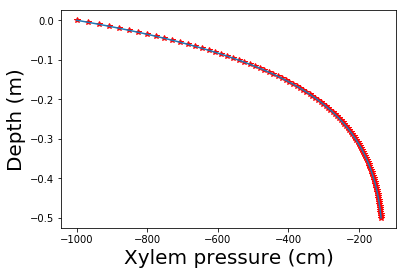

In [11]:
import numpy as np
import scipy.sparse.linalg as LA
from scipy import sparse
import matplotlib.pylab as plt
%matplotlib inline  

import xylem_flux 
import timeit

from math import *

g = 9.8                  # gravitational acceleration (m/s^2)   
rho = 1.e3               # density of water, (kg/m^3)      
ref = 0

def toPa(ph): # cm pressure head to Pascal (kg/ (m s^2))
    return ref - ph/100. * rho * g

def toHead(pa): # Pascal (kg/ (m s^2)) to cm pressure head
    return -(pa-ref) * 100 / rho / g

#
# Compares analytic and numerical solution of a single root
#

# Parameters

L = 0.5;               # length of single straight root (m)
a = 2.e-3              # radius (m)
kz = 5.e-13            # axial conductivity (m^5 s / kg) (mal rho ergibt die alten einheiten)
kr = 2.e-9          # radial conductivity per root type (m^2 s / kg) 

p0 = toPa(-1000)        # dircichlet bc at top (ćm)
pL = toPa(-500)         # dircichlet bc at bot (ćm)
p_s = toPa(-100)        # static soil pressure (cm) 


#
# analytical solution 
# 
# the solution of 
# d^2/dz^2 p_r = - c p_r + c p_s, 
# is 
# p_r = p_s + d_1 exp(sqrt(c) z ) + d_2 exp(-sqrt(c) z)
# with 
# c = 2 a pi kr/kz  
#

c = 2*a*pi*kr/kz

# BC 
# top: p_r(0) = p0
# bot: p_r(-L) = pL 
# bot: qz(L) = 0, -> d/dz p_r (L) = rho*g 

AA = np.array([[1,1], [sqrt(c)*exp(-sqrt(c)*L), -sqrt(c)*exp(sqrt(c)*L)] ]) # dirichlet top, neumann bot
bb = np.array([p0-p_s, rho*g]) #

# AA = np.array([[1,1], [exp(-sqrt(c)*L), exp(sqrt(c)*L)] ]) # dirichlet top & bot
# bb = np.array([p0-p_s, pL-p_s]) #

 
d = np.linalg.solve(AA, bb) # compute constants d_1 and d_2 from bc

p_r = lambda z: toHead( p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z) )

za_ = np.linspace(0,-L,100)
pr = list(map(p_r, za_))
print(0,p_r(0),pr[0])
print(L,p_r(-L),pr[-1])

print(toHead(d))
print(c)

#
# numerical solution
#

nnz = 100

# create grid
nodes = np.zeros((nnz,3))
seg = np.zeros(((nnz-1),2), dtype=int) 
z_ = np.zeros((nnz,1))
c = 0
for i in range(1, nnz):
    seg[c,0] = i-1
    seg[c,1] = i
    c += 1    
    nodes[i,:] = [0.,0.,-i*L/(nnz-1)]
    z_[i] = -i*L/(nnz-1)
 
# from constant to per segment    
kr_ = [kr] * 2*(nnz-1)
kz_ = [kz] * 2*(nnz-1)
a_ = [a] * 2*(nnz-1)
             
# call back function for soil potential
soil = lambda x,y,z : p_s
 
# calculate fluxes within the root system
Q, b = xylem_flux.linear_system(seg, nodes, a_, kr_, kz_, rho, g, soil) #  

# Q, b = xylem_flux.bc_dirichlet(Q, b, np.array([0,nnz-1]), np.array([p0,pL]))
Q, b = xylem_flux.bc_dirichlet(Q, b, np.array([0]), np.array([p0])) # dirichlet top
Q, b = xylem_flux.bc_neumann(Q, b, [nnz-1], [0]) # neumann tip
# plt.spy(Q)
# plt.show()
 
start = timeit.default_timer()
x = LA.spsolve(Q, b, use_umfpack = True) # direct
stop = timeit.default_timer()
# print ("linear system solved in", stop - start, " s") 

# plot results
plt.plot(list(map(toHead, x)),z_,"r*")
plt.plot(pr,za_)
plt.xlabel("Xylem pressure (cm)",fontsize=20);
plt.ylabel("Depth (m)",fontsize=20);
plt.show()

***

## Benchmarking root solute uptake models
Text to explain the root solute uptake benchmarking.
The following code is the analytical solution of the 1D radially symmetric root nutrient uptake model (Roose et al. 2001). 


### The following cell contains code to compute and plot the analytical solution of Roose et al. (2001).

[8640.000000000002, 259200, 604800]


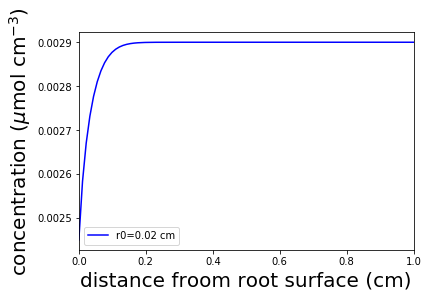

In [15]:
#
# pimplementation of the approximate analytical solution of Roose et al (2001)
#
# A. Schnepf, 2018
#
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate
import scipy.special as sp


r0=0.02; theta=0.32; Phi= 0.45; rho=1; b=39; f=theta**(7/3)/Phi**2; C0=0.046; Cinf=C0; D=1e-5;
Jmax=3e-5/10; Km=0.014; tt=[0.1*24*3600,3*24*3600,7*24*3600]; r1=5.5;
C0=0.0029; b=239;
Jmax = 3.26e-6/10; Km = 0.0058 ;

# compute Roose analytical solution
De=D*f*theta/(theta+b);
Cinf_dl=Cinf/Km;
lambda_=Jmax*r0/(theta*D*f*Km);

x=np.linspace(r0,r1,500);

print(tt)

for k in range(len(tt)):
    d=tt[k]
    L=lambda_/2*np.log(4*np.exp(-0.5772)*De/(r0**2)*d+1)
    C=C0-C0*lambda_/(1+Cinf_dl+L+np.sqrt(4*Cinf_dl+(1-Cinf_dl+L)**2))*sp.expn(1,x**2/(4*De*d));

# plots
plt.figure
plt.plot(x-r0,C,'b-',label="r0=0.02 cm")
plt.xlabel('distance froom root surface (cm)',fontsize=20);
plt.ylabel('concentration ($\mu$mol cm$^{-3}$)',fontsize=20);
plt.xlim((0,1))
plt.legend()
plt.show()